In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

# Add the root project directory to sys.path
sys.path.append(os.path.abspath(".."))

from function.detrend import stationarity_test, arima_detrend

In [3]:
data_dir = "../00_data/03_analysis_data/"
data = pd.read_csv(f"{data_dir}ssami_result.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../00_data/03_analysis_data/ssami_result.csv'

In [4]:
years = data['year'].unique()  # all year
factor_year_coverage = data.groupby('factor')['year'].nunique()  # year covered for each factor

threshold = 1 
min_years_required = int(len(years) * threshold)
complete_factors = factor_year_coverage[factor_year_coverage >= min_years_required].index
filtered_data = data[data['factor'].isin(complete_factors)]

print(f"original number of factors: {data['factor'].nunique()}")
print(f"filtered number of factors with full year coverage: {filtered_data['factor'].nunique()}")

original number of factors: 19
filtered number of factors with full year coverage: 19


In [5]:
filtered_data

,year,cbsacode,factor,ln_pop_beta,ln_pop_p,ln_pop_CI_lower,ln_pop_CI_upper,baseline_moran_value,baseline_moran_p,final_moran_value,final_moran_p,selected_k,SSAMI
0,2011,10740,depressed,0.928707,1.060014e-61,0.898946,0.958468,0.172162,0.008,0.105120,0.069,2,0.132643
1,2011,11260,depressed,0.928707,1.060014e-61,0.898946,0.958468,0.172162,0.008,0.105120,0.069,2,-0.116964
2,2011,12060,depressed,0.928707,1.060014e-61,0.898946,0.958468,0.172162,0.008,0.105120,0.069,2,-0.118365
3,2011,12260,depressed,0.928707,1.060014e-61,0.898946,0.958468,0.172162,0.008,0.105120,0.069,2,-0.128926
4,2011,12420,depressed,0.928707,1.060014e-61,0.898946,0.958468,0.172162,0.008,0.105120,0.069,2,-0.123328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16411,2022,45820,gdp,1.094344,1.979239e-63,1.059750,1.128938,0.079856,0.108,0.079856,0.109,0,-0.066372
16412,2022,46140,gdp,1.094344,1.979239e-63,1.059750,1.128938,0.079856,0.108,0.079856,0.109,0,-0.190427
16413,2022,47260,gdp,1.094344,1.979239e-63,1.059750,1.128938,0.079856,0.108,0.079856,0.109,0,-0.252789
16414,2022,48620,gdp,1.094344,1.979239e-63,1.059750,1.128938,0.079856,0.108,0.079856,0.109,0,-0.058133


In [6]:
stationarity_results = stationarity_test(
    data= filtered_data,
    factor_column='factor',
    cbsa_column='cbsacode',
    sami_column='SSAMI'
)

Processing factor: depressed
Processing factor: poor_or_fair_health
Processing factor: uninsured_adults
Processing factor: primary_care_physicians
Processing factor: adult_smoking
Processing factor: adult_obesity
Processing factor: unemployment
Processing factor: low_birthweight
Processing factor: sexually_transmitted_infections
Processing factor: excessive_drinking
Processing factor: rural
Processing factor: not_proficient_in_english
Processing factor: diabetes_prevalence
Processing factor: mental_health_providers
Processing factor: median_household_income
Processing factor: driving_alone_to_work
Processing factor: some_college
Processing factor: children_in_single-parent_households
Processing factor: gdp


In [7]:
nstationary = stationarity_results.loc[(stationarity_results['Stationary'] == False)].dropna()
nstationary.shape

(950, 6)

In [8]:
filtered_data1 = filtered_data.merge(nstationary, 
                           left_on=['cbsacode', 'factor'], 
                           right_on=['CBSA', 'Factor'],how='inner')

In [9]:
filtered_data1.shape

(11400, 19)

In [10]:
import pandas as pd
from scipy.signal import detrend

# Assuming `filtered_data` is your DataFrame
# Ensure the data is sorted by 'cbsacode' and 'year'
filtered_data1 = filtered_data1.sort_values(by=['cbsacode', 'year'])

# Initialize a column for detrended SSAMI
filtered_data1['SSAMI_detrended'] = None

# Group by 'factor' and 'cbsacode'
grouped = filtered_data1.groupby(['factor', 'cbsacode'])

# Apply detrending to each group
for (factor, cbsacode), group in grouped:
    ssami_values = group['SSAMI'].values  # Get the SSAMI values for this group
    detrended_values = detrend(ssami_values, type='linear')  # Remove the linear trend
    filtered_data1.loc[group.index, 'SSAMI_detrended'] = detrended_values  # Assign detrended values

# Save the detrended data to a new file
#filtered_data.to_csv(f"{output_dir}detrended_ssami.csv", index=False)

print("Detrending complete.")

Detrending complete.


In [11]:
stationarity_results2 = stationarity_test(
    data= filtered_data1,
    factor_column='factor',
    cbsa_column='cbsacode',
    sami_column='SSAMI_detrended'
)

Processing factor: depressed
Processing factor: poor_or_fair_health
Processing factor: uninsured_adults
Processing factor: adult_smoking
Processing factor: adult_obesity
Processing factor: low_birthweight
Processing factor: not_proficient_in_english
Processing factor: diabetes_prevalence
Processing factor: mental_health_providers
Processing factor: median_household_income
Processing factor: some_college
Processing factor: gdp
Processing factor: primary_care_physicians
Processing factor: unemployment
Processing factor: sexually_transmitted_infections
Processing factor: rural
Processing factor: driving_alone_to_work
Processing factor: children_in_single-parent_households
Processing factor: excessive_drinking


In [12]:
stationarity_results2.shape

(950, 6)

In [13]:
nstationary2 = stationarity_results2.loc[(stationarity_results2['Stationary'] == False)].dropna()
nstationary2.shape

(658, 6)

In [14]:
filtered_data2 = filtered_data1.merge(nstationary2, 
                           left_on=['cbsacode', 'factor'], 
                           right_on=['CBSA', 'Factor'],how='inner')

In [ ]:


# Example usage
# Assuming `filtered_data` contains columns: 'year', 'cbsacode', 'SAMI'
filtered_data2 = arima_detrend(filtered_data2, cbsa_column='cbsacode', sami_column='SSAMI', order=(1, 1, 0))

# Save the detrended data
#filtered_data.to_csv(f"{output_dir}detrended_ssami_arima.csv", index=False)
print("ARIMA detrended finished.")

ARIMA detrended finished.


In [16]:
stationarity_results3 = stationarity_test(
    data= filtered_data2,
    factor_column='factor',
    cbsa_column='cbsacode',
    sami_column='SAMI_detrended_arima'
)

Processing factor: depressed
Processing factor: uninsured_adults
Processing factor: adult_smoking
Processing factor: adult_obesity
Processing factor: low_birthweight
Processing factor: not_proficient_in_english
Processing factor: mental_health_providers
Processing factor: median_household_income
Processing factor: some_college
Processing factor: gdp
Processing factor: primary_care_physicians
Processing factor: unemployment
Processing factor: rural
Processing factor: diabetes_prevalence
Processing factor: driving_alone_to_work
Processing factor: children_in_single-parent_households
Processing factor: poor_or_fair_health
Processing factor: excessive_drinking
Processing factor: sexually_transmitted_infections


In [17]:
stationarity_results3.shape

(658, 6)

In [18]:
nstationary3 = stationarity_results3.loc[(stationarity_results3['Stationary'] == False)].dropna()
nstationary3.shape

(490, 6)

In [19]:
filtered_data['SSAMI_d'] = filtered_data['SSAMI']
filtered_data['METHOD'] = 'original'

filtered_data1['SSAMI_d'] = filtered_data1['SSAMI_detrended']
filtered_data1['METHOD'] = 'linear'

filtered_data2['SSAMI_d'] = filtered_data2['SAMI_detrended_arima']
filtered_data2['METHOD'] = 'arima'

In [20]:
combined_data = pd.concat([filtered_data, 
                           filtered_data1, 
                           filtered_data2], ignore_index=True)[['cbsacode','year','factor','SSAMI_d','METHOD']]

In [21]:
combined_data

,cbsacode,year,factor,SSAMI_d,METHOD
0,10740,2011,depressed,0.132643,original
1,11260,2011,depressed,-0.116964,original
2,12060,2011,depressed,-0.118365,original
3,12260,2011,depressed,-0.128926,original
4,12420,2011,depressed,-0.123328,original
...,...,...,...,...,...
35707,49340,2022,rural,0.200309,arima
35708,49340,2022,not_proficient_in_english,0.362242,arima
35709,49340,2022,diabetes_prevalence,-0.467451,arima
35710,49340,2022,driving_alone_to_work,-0.12517,arima


In [22]:
# Sort the data by METHOD preference (arima > linear > original)
method_order = {'arima': 1, 'linear': 2, 'original': 3}
combined_data['method_rank'] = combined_data['METHOD'].map(method_order)

# Sort by year, CBSA, and method rank (ascending)
combined_data = combined_data.sort_values(by=['year', 'cbsacode','factor', 'method_rank'])

# Keep the first (highest-priority) method for each year-CBSA pair
deduplicated_data = combined_data.drop_duplicates(subset=['year', 'cbsacode','factor'], keep='first')

# Drop the helper column 'method_rank'
deduplicated_data = deduplicated_data.drop(columns=['method_rank'])

# Save the final dataset (optional)
#deduplicated_data.to_csv(f"{output_dir}detrend_ssami_data.csv", index=False)

# Display results
#print("Deduplicated data shape:", deduplicated_data.shape)
print(deduplicated_data.head())

       cbsacode  year                                factor   SSAMI_d  \
27819     10740  2011                         adult_obesity -0.255189   
27818     10740  2011                         adult_smoking -0.130169   
1224      10740  2011  children_in_single-parent_households  0.266437   
27816     10740  2011                             depressed  0.132643   
16423     10740  2011                   diabetes_prevalence -0.006633   

         METHOD  
27819     arima  
27818     arima  
1224   original  
27816     arima  
16423    linear  


In [23]:
deduplicated_data

,cbsacode,year,factor,SSAMI_d,METHOD
27819,10740,2011,adult_obesity,-0.255189,arima
27818,10740,2011,adult_smoking,-0.130169,arima
1224,10740,2011,children_in_single-parent_households,0.266437,original
27816,10740,2011,depressed,0.132643,arima
16423,10740,2011,diabetes_prevalence,-0.006633,linear
...,...,...,...,...,...
35707,49340,2022,rural,0.200309,arima
15695,49340,2022,sexually_transmitted_infections,-0.147637,original
27814,49340,2022,some_college,-0.001853,linear
35705,49340,2022,unemployment,0.138385,arima


In [24]:
deduplicated_data.to_csv(f'../output/detrend_result.csv',index=False)

---

In [25]:
stationarity_results_f = stationarity_test(
    data= deduplicated_data,
    factor_column='factor',
    cbsa_column='cbsacode',
    sami_column='SSAMI_d'
)

Processing factor: adult_obesity
Processing factor: adult_smoking
Processing factor: children_in_single-parent_households
Processing factor: depressed
Processing factor: diabetes_prevalence
Processing factor: driving_alone_to_work
Processing factor: excessive_drinking
Processing factor: gdp
Processing factor: low_birthweight
Processing factor: median_household_income
Processing factor: mental_health_providers
Processing factor: not_proficient_in_english
Processing factor: poor_or_fair_health
Processing factor: primary_care_physicians
Processing factor: rural
Processing factor: sexually_transmitted_infections
Processing factor: some_college
Processing factor: unemployment
Processing factor: uninsured_adults


---
# Visulization

/tmp/ipykernel_1422477/1293282077.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  binary_heatmap_data = heatmap_data.replace({True: 1, False: 0})


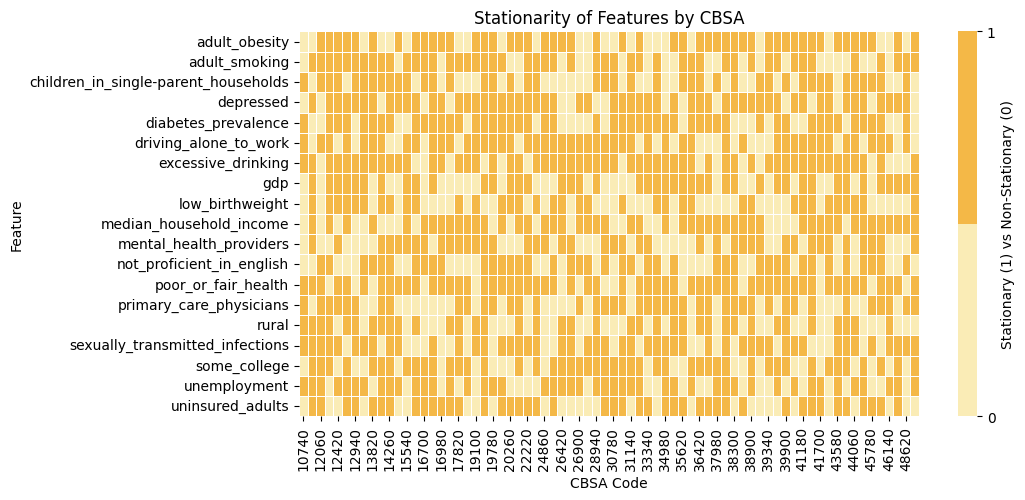

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette using similar colors from the provided palette
custom_colors = ['#FAECB6', '#F4B847']  # non-stationary, yellow for stationary

bar = stationarity_results_f.dropna()
# Assuming 'CBSA' and 'Factor' are columns in results_df

# Prepare data for heatmap by pivoting the DataFrame
heatmap_data = bar.pivot(index='Factor',  # Features as rows
                         columns='CBSA',  # CBSA codes as columns
                         values='Stationary').fillna(False)

# Convert boolean True/False to binary labels 1 (Stationary) and 0 (Non-Stationary)
binary_heatmap_data = heatmap_data.replace({True: 1, False: 0})

# Plot heatmap with discrete color levels (0 and 1 only)
plt.figure(figsize=(10, 5))
sns.heatmap(binary_heatmap_data,
            cmap=sns.color_palette(custom_colors),
            cbar_kws={'ticks': [0, 1], 'label': 'Stationary (1) vs Non-Stationary (0)'},
            linewidths=0.5, linecolor='white')  # Add grid lines for better separation
plt.xlabel("CBSA Code")
plt.ylabel("Feature")
plt.title("Stationarity of Features by CBSA")
plt.show()